In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.stats as sts
import matplotlib.pyplot as plt

Константный размер для графиков

In [2]:
sns.set(rc={'figure.figsize':(12, 7)})

In [118]:
df = pd.read_csv('credit_scoring_analysis.csv', sep=',')

In [67]:
df.head(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


# Размер кредитного лимита

Разобьем наш датасет на две подвыборки: первая будет содержать только информацию о заёмщиках, которые вернули кредит (`returned_bal`), вторая только о тех, кто не вернул (`non_returned_bal`).

In [13]:
returned_bal = df[df['default'] == 0]
non_returned_bal = df[df['default'] == 1]

<AxesSubplot:xlabel='LIMIT_BAL', ylabel='Count'>

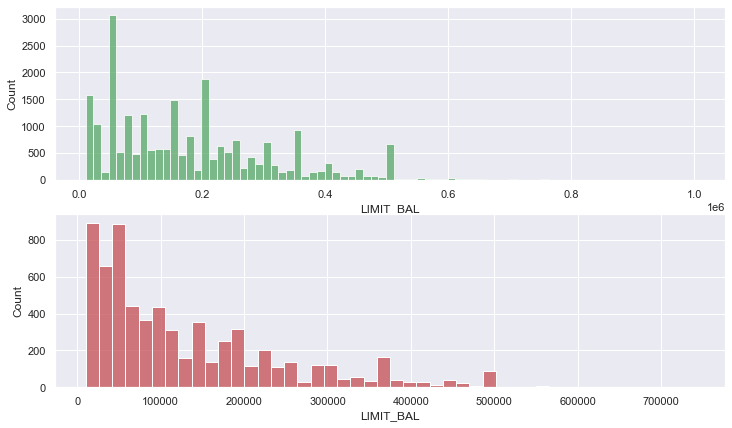

In [14]:
_, ax = plt.subplots(2)
sns.histplot(data=returned_bal, x='LIMIT_BAL', color='g', ax=ax[0])
sns.histplot(data=non_returned_bal, x='LIMIT_BAL', color='r', ax=ax[1])

((array([-4.01544493, -3.80115573, -3.68397676, ...,  3.68397676,
          3.80115573,  4.01544493]),
  array([  10000,   10000,   10000, ...,  800000,  800000, 1000000])),
 (126251.39979407027, 178099.7260743024, 0.9590119112004252))

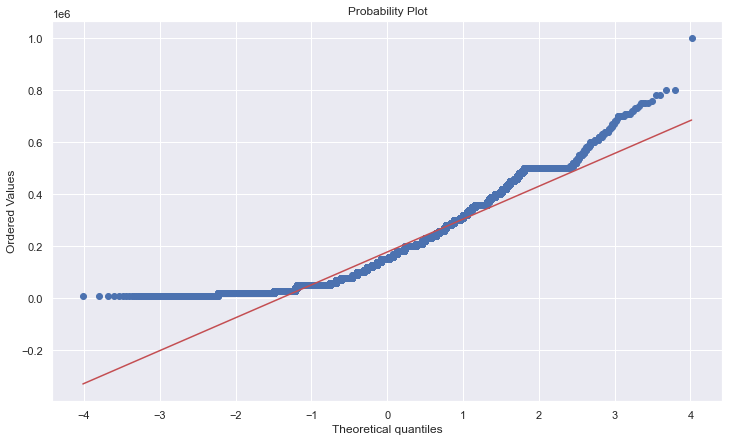

In [15]:
sts.probplot(returned_bal['LIMIT_BAL'], dist='norm', plot=plt)

((array([-3.70801024, -3.47700165, -3.34989414, ...,  3.34989414,
          3.47700165,  3.70801024]),
  array([ 10000,  10000,  10000, ..., 710000, 720000, 740000])),
 (106735.76934970939, 130109.65641952983, 0.9246829345320482))

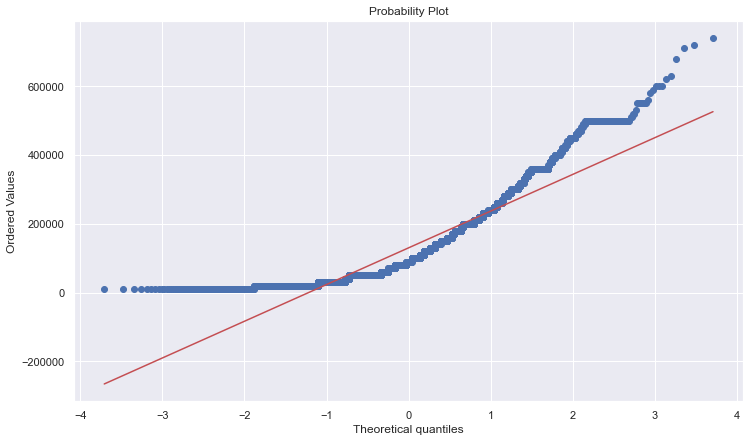

In [16]:
sts.probplot(non_returned_bal['LIMIT_BAL'], dist='norm', plot=plt)

Распределения имеют значительные отклонения от нормального, поэтому применять параметрические критерии даже предусматривающие незначительные отклонения от нормального распределения нельзя.

Поэтому воспользуемся бутстрепом и построим 95% доверительный интервал для разности медиан (можно по отдельности, главное чтобы они не пересекались) кредитного лимита между заемщиками которые вернули/нет, кредит, и посмотрим на различия между медианами выборок. Выборки являются достаточно репрезентативными.  

In [31]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    
    return samples

def build_confint(stat_sample, alpha: float = .05):
    boundaries = np.percentile(stat_sample, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    
    return boundaries

In [46]:
n_samples = 2500
alpha = 0.05

stat_sample_r = np.array(list(map(np.median, get_bootstrap_samples(returned_bal['LIMIT_BAL'].values, n_samples))))
stat_sample_nr = np.array(list(map(np.median, get_bootstrap_samples(non_returned_bal['LIMIT_BAL'].values, n_samples))))

diff_stat_sample = stat_sample_r - stat_sample_nr

In [49]:
print(f'{100 - 100*alpha}% confint for people, who returned a credit: '
      f'{build_confint(stat_sample_r ,alpha=alpha)}\n'
      f'\t\t\t  who not return a credit: {build_confint(stat_sample_nr, alpha=alpha)}\n')

print(f'Or, for difference between r/nr samples: {build_confint(diff_stat_sample, alpha=alpha)}')

95.0% confint for people, who returned a credit: [150000. 150000.]
			  who not return a credit: [80000. 90000.]

Or, for difference between r/nr samples: [60000. 70000.]


Теперь мы с уверенностью можем сказать, что размер кредитного лимита различается между группами заемщиков, которые кредит вернули, и которые - нет. И ведь это логично, заемщикам с испорченной кредитной историей взаймы давать будут напорядок меньше (лимит меньше), чем тем, кто добросовестно возвращал кредит, им дают больше: 95%  доверительный интервал на основании бутстрепа показывает, что медианы различаются на [60000, 70000], точечная оценка - 65000.

Теперь посмотрим на то, различаются ли входные распределения лимита групп, кто кредит возвращал, а кто - нет. 

Распределения имеют значительные отклонения от нормального, поэтому применять параметрические критерии даже предусматривающие незначительное отклонения от нормального распределения нельзя, воспользуемся ранговым критерием Манна-Уитни для независимых выборок, проверяется гипотеза о том, что выборки пришли из одинаковых распределений против двусторонней альтернативы о том, что это не так (со сдвигом):

$$H_0: F_{X_1(x)} = F_{X_2(x)}$$
$$H_1: F_{X_1(x)} = F_{X_2(x + \Delta)}, \ \ \Delta <\neq> 0$$

In [17]:
sts.mannwhitneyu(returned_bal['LIMIT_BAL'], non_returned_bal['LIMIT_BAL'])

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

Как мы видим, на уровне значимости 0.05 отклоняем $H_0$ c достаточно низким значением достигаемого уровня значимости 6.127742909111652e-190, что дает нам право полагать, что размер кредитного лимита практически значим в задаче кредитного скоринга.

# Пол

In [85]:
returned_sex_group = df[df.default == 0].SEX
non_returned_sex_group = df[df.default == 1].SEX

In [86]:
returned_sex_group.value_counts()

2    14349
1     9015
Name: SEX, dtype: int64

In [87]:
non_returned_sex_group.value_counts()

2    3763
1    2873
Name: SEX, dtype: int64

Нельзя делать из этого какие-либо выводы, нужно использовать более обоснованные аргументы о различии гендерного состава в двух группах.

В нашем случае будет достаточно использовать параметрический критерий о долях для независимых выборок, а именно, например проверить гипотезу о различии доли мужчин в двух подвыборках (тех кто вернул кредит и нет), ну и построить доверительный интервал для разности долей мужчин.

Если обнаружится статистическая значимость среди долей, то это автоматически значит, что и доли женщин также различаются статистически значимо.

## Способ первый: критерий о долях для независимых выборок

Проверим гипотезу о том, что доли мужчин в двух подвыборках различаются (вероятности встретить мужчину в выборках равны, различий нет), против альтернативы, что это не так (вероятности не равны):

$$H_0: p_1 - p_2=0$$
$$H_0: p_1 - p_2\neq0$$

$$\hat p_1 = \frac{men_1}{n_1}, \hat p_2= \frac{men_2}{n_2} \rightarrow \hat p_1 - \hat p_2$$

$$\text{Доверительный интервал для } \hat p_1 - \hat p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

$$Z-статистика: Z({X_1^{n_1}, X_2^{n_2}}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

Заменим в выборке 2 - женщины, на 0, чтобы выборка стала бинарной и можно было применить z-test (критерий о долях), основанный на ЦПТ:

In [119]:
df['SEX_binary'] = df['SEX'].apply(lambda sex: 0 if sex == 2 else 1)

returned_sex_group = df[df.default == 0].SEX_binary
non_returned_sex_group = df[df.default == 1].SEX_binary

In [60]:
def proportions_diff_z_test_ind(f_sample, s_sample, alternative='two-sided'):
    possible_alternatives = ('less', 'higher', 'two-sided')
    if alternative not in possible_alternatives:
        raise ValueError(f'The is no such alternative: {alternative}. '
                        f'Choose between {possible_alternatives}')
        
    p1 = np.sum(f_sample) / len(f_sample)
    p2 = np.sum(s_sample) / len(s_sample)
    
    n1, n2 = len(f_sample), len(s_sample)
    
    P = (p1*n1 + p2*n2) / (n1 + n2)
    
    z_stat = (p1 - p2) / (np.sqrt(P * (1 - P) * (1/n1 + 1/n2)))
    
    p_value = None
    if alternative == 'less':
        p_value = sts.norm.cdf(z_stat)
    if alternative == 'higher':
        p_value = 1 - sts.norm.cdf(z_stat)
    if alternative == 'two-sided':
        p_value = 2 * (1 - sts.norm.cdf(abs(z_stat)))
    
    return {'alternative': alternative,'p_value': p_value}

In [91]:
proportions_diff_z_test_ind(returned_sex_group, non_returned_sex_group, alternative='two-sided')

{'alternative': 'two-sided', 'p_value': 4.472866521609831e-12}

Как мы видим, z-test для разности двух долей мужчин в выборках различается статистически значимо. Отклояем $H_0$ о равенстве долей мужчин, соответственно это значит, что и доля женщин также отличается статистически значимо (принимаем $H_1$).

В целом получаем, что гендерный состав в группах людей которые вернули/нет кредит - различается.

## Способ второй: доверительный интервал для разности долей двух подвыборок

$$\text{Доверительный интервал для } \hat p_1 - \hat p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

In [92]:
def proportions_diff_confint_ind(f_sample, s_sample, alpha=.05):
    z = sts.norm.ppf(1 - alpha/2)
    
    p1 = np.sum(f_sample) / len(f_sample)
    p2 = np.sum(s_sample) / len(s_sample)
    
    n1, n2 = len(f_sample), len(s_sample)
    
    left_bound = p1 - p2 - z * np.sqrt(p1*(1 - p1)/n1 + p2*(1 - p2)/n2)
    right_bound = p1 - p2 + z * np.sqrt(p1*(1 - p1)/n1 + p2*(1 - p2)/n2)

    return {f'{(1 - alpha)*100}% confint': (left_bound, right_bound)}

In [93]:
proportions_diff_confint_ind(returned_sex_group, non_returned_sex_group, alpha=.05)

{'95.0% confint': (-0.060548077974896725, -0.03363493274962867)}

Здесь мы видим, что 95% доверительный интервал для разности долей мужчин лежит левее нуля, что свидетельствует о том, что доли в двух подвыборках неравны, более того, доля мужчин вернувших кредит меньше, чем не вернувших.

Точечная оценка 95% доверительного интервала --    -0.04709

Подводя итог, можно сказать, что мужчины реже берут кредит, но чаще его не возвращают. Так как разница долей статистически значима, то признак `SEX` должен учитываться при построении модели.

# Образование


In [120]:
def convert_edu_labels(label):
    if label == 0:
        return 'phd'
    if label == 1:
        return 'master'
    if label == 2:
        return 'bachelor'
    if label == 3:
        return 'school graduate'
    if label == 4:
        return 'elementary education'
    if label == 5:
        return 'other'
    if label == 6:
        return 'no info'

In [121]:
df['EDUCATION_labels'] = df['EDUCATION'].apply(convert_edu_labels)
df['default_labels'] = df['default'].apply(lambda x: 'non_returned' if x == 1 else 'returned')

<AxesSubplot:xlabel='EDUCATION_labels', ylabel='count'>

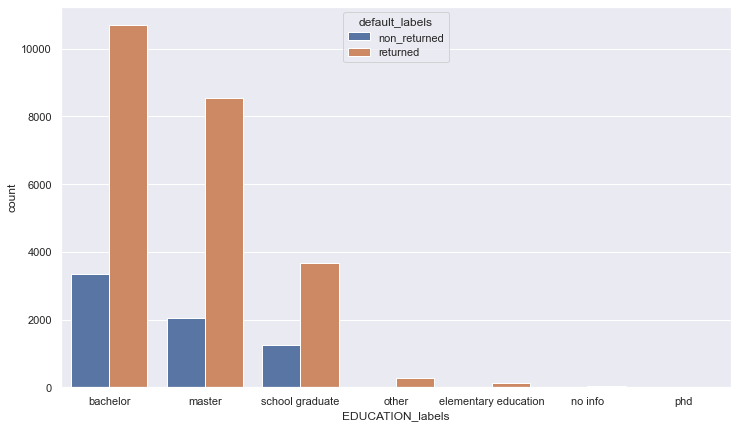

In [122]:
sns.countplot(data=df, x='EDUCATION_labels', hue='default_labels')

<AxesSubplot:xlabel='EDUCATION_labels', ylabel='Count'>

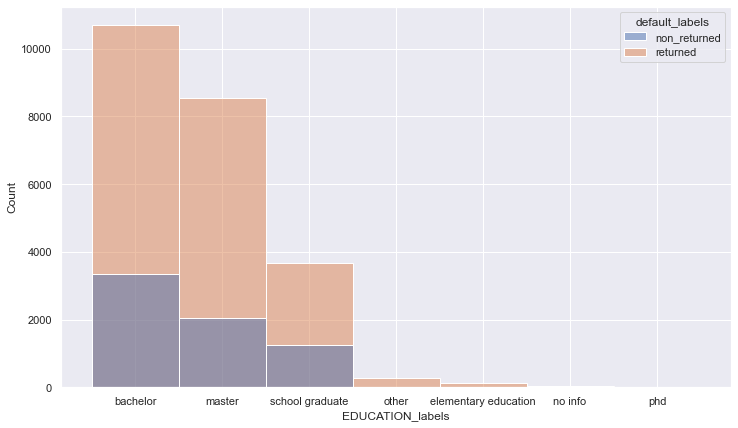

In [143]:
sns.histplot(data=df, x='EDUCATION_labels', hue='default_labels')

Видно, что чаще всего берут кредит бакалавры и магистры, выпускники школы реже, доктора почти не берут, чаще всего не возвращают бакалавры из тех что берут. 

Теперь создадим таблицу сопряженности, где будет хранится количество людей со всеми уровнями образования в двух подвыборках.

In [160]:
education_levels = ['phd', 'master', 'bachelor', 'hs_graduate', 'elementary_edu', 'other', 'no_info']

returned_group_edu = df[df.default == 0].EDUCATION
non_returned_group_edu = df[df.default == 1].EDUCATION

adjacency_matrix = pd.DataFrame({'returned': returned_group_edu.value_counts(), \
                                 'non_returned': non_returned_group_edu.value_counts()})

for i, edu_level in enumerate(education_levels):
    adjacency_matrix.rename(index={i: edu_level}, inplace = True)
    
adjacency_matrix.iloc[0, 1] = 0

In [161]:
adjacency_matrix

,returned,non_returned
phd,14,0.0
master,8549,2036.0
bachelor,10700,3330.0
hs_graduate,3680,1237.0
elementary_edu,116,7.0
other,262,18.0
no_info,43,8.0


В таблице сопряженности значения - типичные счетчики, поэтому можно попробовать оценить распределением Пуассона.
Лучшая оценка на параметр $\lambda$ - типичное среднее, возьмем 2

In [145]:
df.EDUCATION.mean()

1.8531333333333333

Проверим гипотезу о том, что наша случайная величина принадлежит распределению Пуассона с $\lambda = 2$ против альтернативы что это не так

In [150]:
chi2, p_value, dof, ex = sts.chi2_contingency(adjacency_matrix, correction=False)

In [151]:
p_value

1.2332626245415605e-32

Можем смело отвергнуть $H_0$ на уровне значимости $0.05$ о том, что это распределение Пуассона с достигаемым уровнем значимости 1.2332626245415605e-32.

Признак `EDUCATION` является статистически значимым в оценке вероятности возврата кредита.

# Семейное положение

In [155]:
df[df.default == 0].MARRIAGE.value_counts()

2    12623
1    10453
3      239
0       49
Name: MARRIAGE, dtype: int64

In [156]:
df[df.default == 1].MARRIAGE.value_counts()

2    3341
1    3206
3      84
0       5
Name: MARRIAGE, dtype: int64

Проверить взаимосвязь признаков можно проверить с помощью коэффициента V Крамера, он подходит хорошо, так как рассматриваемый признак категориальный.

In [176]:
def v_cramer(chi_stat, n, shape):
    return np.sqrt(chi_stat / n / (min(shape[0], shape[1]) - 1))

In [173]:
marriage_status = ['reject_to_answer', 'married', 'single', 'no_data']

returned_group_marr = df[df.default == 0].MARRIAGE
non_returned_group_marr = df[df.default == 1].MARRIAGE

adjacency_matrix_marriage = pd.DataFrame({'returned': returned_group_marr.value_counts(), \
                                         'non_returned': non_returned_group_marr.value_counts()})

for i, marr_stat in enumerate(marriage_status):
    adjacency_matrix_marriage.rename(index={i: marr_stat}, inplace = True)

In [177]:
chi_stat = sts.chi2_contingency(adjacency_matrix_marriage, correction=False)[0]
n = len(df)
adj_matr_shape = adjacency_matrix_marriage.shape

v_cramer(chi_stat, n, adj_matr_shape)

0.034478203662766466

Как мы видим, взаимосвязь между целевой переменной и признаком `MARRIAGE`, измеренная с помощью коэффициента V Крамера достаточно низкая, поэтому, этот признак включать в модель не стоит, он имеет низкую корреляцию с целевой переменной.

# Возраст

Как и в случае признака кредитного лимита воспользуемся непараметрическим критерием Манна-Уитни

In [181]:
returned_bal_age = df[df.default == 0]
non_returned_bal_age = df[df.default == 1]

<AxesSubplot:xlabel='AGE', ylabel='Count'>

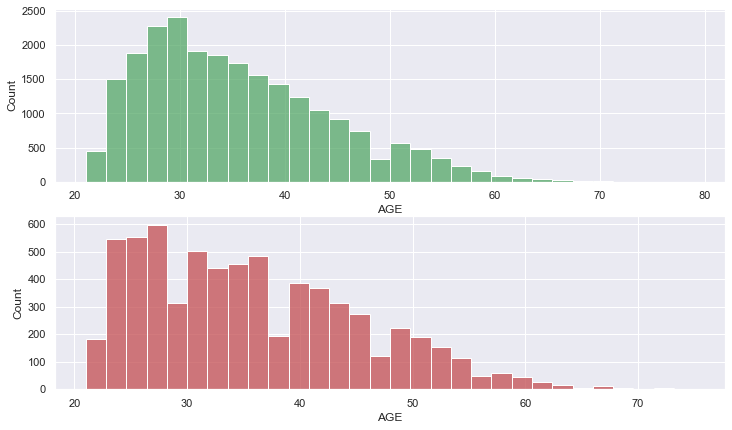

In [198]:
_, ax = plt.subplots(2)

sns.histplot(data=returned_bal_age, x='AGE', color='g', ax=ax[0], bins=30)
sns.histplot(data=non_returned_bal_age, x='AGE', color='r', ax=ax[1], bins=30)

((array([-4.01544493, -3.80115573, -3.68397676, ...,  3.68397676,
          3.80115573,  4.01544493]),
  array([21, 21, 21, ..., 75, 75, 79])),
 (8.846969314068657, 35.417265879130284, 0.974478998779362))

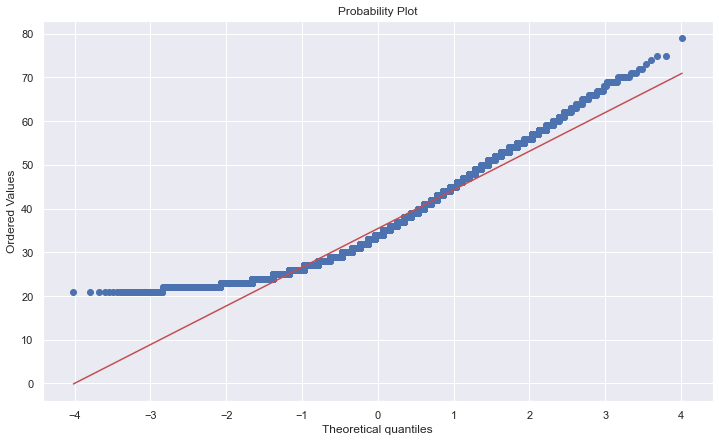

In [206]:
sts.probplot(returned_bal_age['AGE'], dist='norm', plot=plt)

((array([-3.70801024, -3.47700165, -3.34989414, ...,  3.34989414,
          3.47700165,  3.70801024]),
  array([21, 21, 21, ..., 73, 73, 75])),
 (9.453763999193253, 35.72573839662447, 0.9748432681275312))

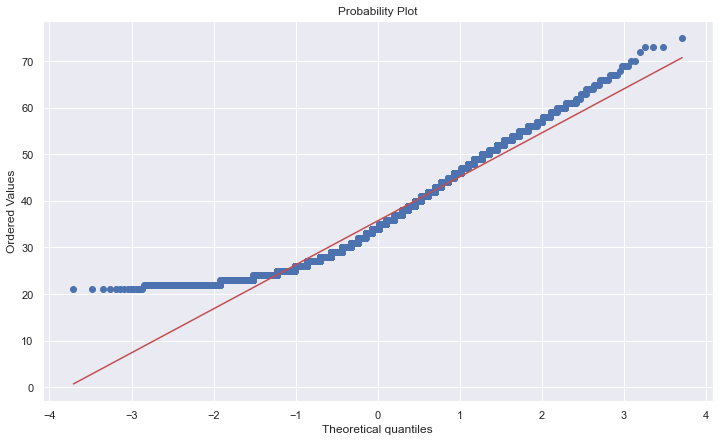

In [207]:
sts.probplot(non_returned_bal_age['AGE'], dist='norm', plot=plt)

Здесь уже менее значительные отклонения, но все равно они есть, поэтому снова воспользуемся непараметрическим критерием Манна-Уитни и доверительным интервалом для разности медиан на основании бутстрепа:

$$H_0\colon F_{X_{1}}(x) = F_{X_{2}}(x)$$
$$H_1\colon F_{X_{1}}(x) = F_{X_{2}}(x + \Delta), \Delta\neq 0$$

## Способ первый: Критерий Манна-Уитни

In [208]:
sts.mannwhitneyu(returned_bal_age['AGE'], non_returned_bal_age['AGE'])

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

На уровне значимости 0.05 мы не можем отклонить $H_0$ о том, что медианы в подвыборках не различаются с достигаемым уровнем значимости 0.1862517717449308

## Способ второй: Доверительный интервал на основании бутстрепа для разности медиан

In [210]:
n_samples = 2500
alpha = 0.05

stat_sample_r = np.array(list(map(np.median, get_bootstrap_samples(returned_bal_age['AGE'].values, n_samples))))
stat_sample_nr = np.array(list(map(np.median, get_bootstrap_samples(non_returned_bal_age['AGE'].values, n_samples))))

diff_stat_sample = stat_sample_r - stat_sample_nr

In [211]:
print(f'{100 - 100*alpha}% confint for people, who returned a credit: '
      f'{build_confint(stat_sample_r ,alpha=alpha)}\n'
      f'\t\t\t  who not return a credit: {build_confint(stat_sample_nr, alpha=alpha)}\n')

print(f'Or, for difference between r/nr samples: {build_confint(diff_stat_sample, alpha=alpha)}')

95.0% confint for people, who returned a credit: [34. 34.]
			  who not return a credit: [34. 35.]

Or, for difference between r/nr samples: [-1.  0.]


Здесь все тоже очевидно, 0 входит в доверительный интервал для разности медиан, что свидетельствует о том, что на уровне значимости 0.05 мы не можем отклонить $H_0$ о неразличии медиан, т.е мы не можем утверждать что медианы в подвыборках различаются.

Данный признак в модель включать не стоит, так как мы не можем никак утверждать, что он как-то влияет на целевой признак `default`